In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from datetime import datetime

In [212]:
df = pd.read_csv(r"C:\Users\Admin\Downloads\household_power_consumption.csv")

In [213]:
# Kiểm tra các cột trong DataFrame
print("Các cột trong DataFrame:", df.columns)

Các cột trong DataFrame: Index(['index', 'Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')


In [214]:
# Kết hợp Date và Time thành cột datetime
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%m/%d/%Y %H:%M:%S')
df = df.dropna(subset=['DateTime'])

In [215]:
# Chuyển Global_active_power thành số thực, xử lý giá trị không hợp lệ
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df = df.dropna(subset=['Global_active_power'])

In [216]:
# Lấy mẫu lại dữ liệu theo giờ
df.set_index('DateTime', inplace=True)
df_hourly = df['Global_active_power'].resample('H').mean().dropna()

C:\Users\Admin\AppData\Local\Temp\ipykernel_5800\3061356342.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df['Global_active_power'].resample('H').mean().dropna()


In [217]:
# Chuẩn bị dữ liệu cho FFT
signal = df_hourly.values
n = len(signal)
sample_rate = 1  # 1 mẫu mỗi giờ
t = np.arange(n) / sample_rate

In [218]:
# Thực hiện FFT
yf = fft(signal)
xf = fftfreq(n, 1 / sample_rate)

In [219]:
# Lấy nửa phổ dương
positive_freqs = xf[:n//2]
positive_amplitudes = np.abs(yf)[:n//2] / n

In [220]:
# Xác định chu kỳ chiếm ưu thế
periods = 1 / positive_freqs[positive_freqs > 0]  # Chuyển tần số thành chu kỳ (giờ)
amplitudes = positive_amplitudes[positive_freqs > 0]

In [221]:
# Tìm 5 chu kỳ chiếm ưu thế
peaks_idx = np.argsort(amplitudes)[-5:]  # Lấy 5 đỉnh lớn nhất
dominant_periods = periods[peaks_idx]

In [222]:
# Làm tròn và lọc chu kỳ
max_period = 720  # Giới hạn chu kỳ tối đa là 1 tháng (720 giờ)
filtered_periods = np.round(dominant_periods[dominant_periods <= max_period], 2)
filtered_amplitudes = amplitudes[peaks_idx][dominant_periods <= max_period]

In [223]:
# Tạo mô tả cho các chu kỳ
period_labels = []
for period in filtered_periods:
    if 23 <= period <= 25:
        period_labels.append(f"{period} giờ (hàng ngày)")
    elif 11 <= period <= 13:
        period_labels.append(f"{period} giờ (nửa ngày)")
    elif 167 <= period <= 169:
        period_labels.append(f"{period} giờ (hàng tuần)")
    else:
        period_labels.append(f"{period} giờ")

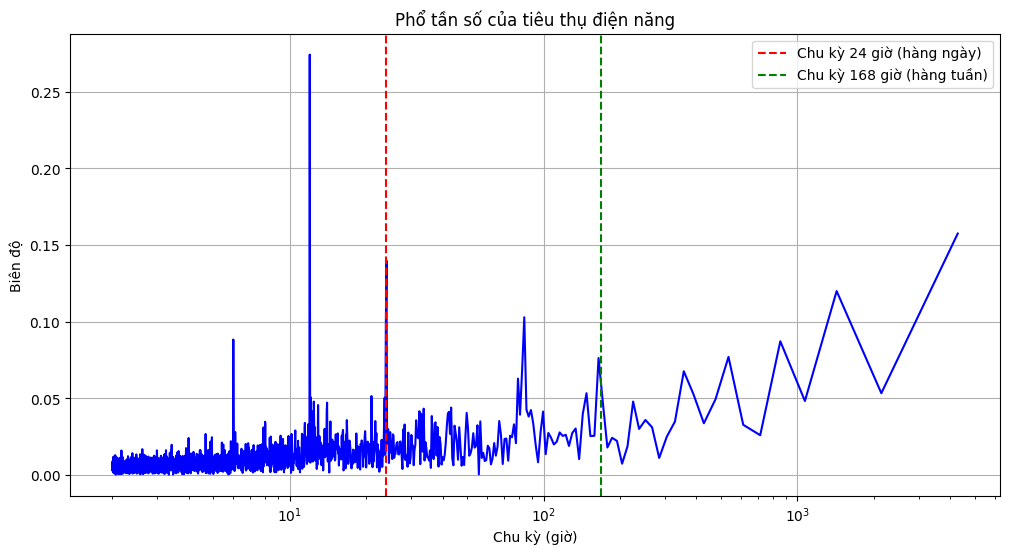

In [224]:
# Vẽ biểu đồ phổ tần số
plt.figure(figsize=(12, 6))
plt.plot(periods, amplitudes, 'b-')
plt.xscale('log')
plt.xlabel('Chu kỳ (giờ)')
plt.ylabel('Biên độ')
plt.title('Phổ tần số của tiêu thụ điện năng')
plt.grid(True)
plt.axvline(x=24, color='r', linestyle='--', label='Chu kỳ 24 giờ (hàng ngày)')
plt.axvline(x=168, color='g', linestyle='--', label='Chu kỳ 168 giờ (hàng tuần)')
plt.legend()
plt.savefig('fft_spectrum.png')

In [225]:
# Phân tích tiêu thụ trung bình theo giờ
df['hour'] = df.index.hour
hourly_avg = df.groupby('hour')['Global_active_power'].mean()

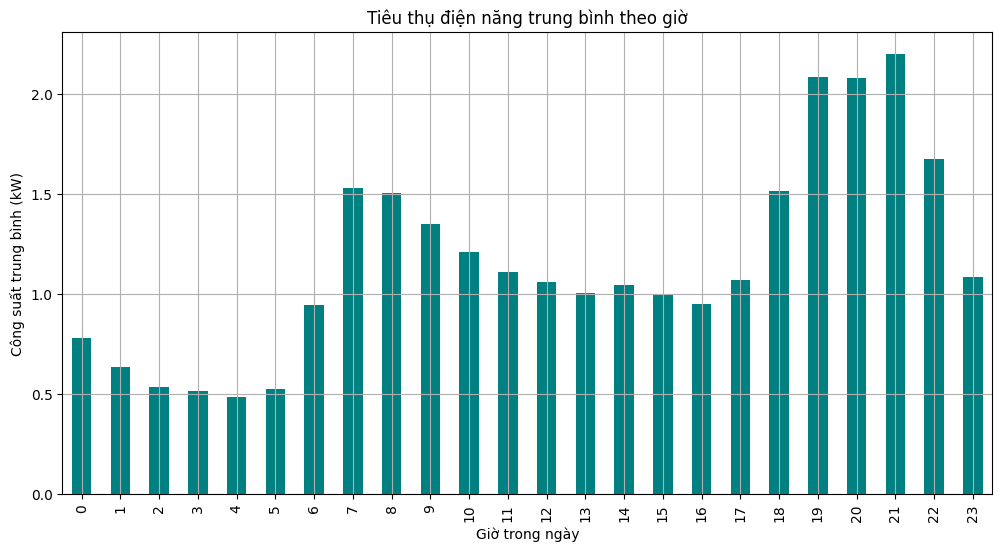

In [226]:
# Vẽ biểu đồ tiêu thụ trung bình theo giờ
plt.figure(figsize=(12, 6))
hourly_avg.plot(kind='bar', color='teal')
plt.xlabel('Giờ trong ngày')
plt.ylabel('Công suất trung bình (kW)')
plt.title('Tiêu thụ điện năng trung bình theo giờ')
plt.grid(True)
plt.savefig('hourly_consumption.png')

In [227]:
# Xác định các giờ tiêu thụ cao
peak_hours = hourly_avg[hourly_avg > 1.5].index.tolist()

# In kết quả
print("Chu kỳ chiếm ưu thế (làm tròn đến 2 chữ số thập phân, tối đa 1 tháng):")
for period, label in zip(filtered_periods, period_labels):
    print(f"- {label}")
print("\nCác giờ tiêu thụ cao trong ngày (> 1.5 kW):", peak_hours if peak_hours else "Không có giờ nào có công suất trung bình > 1.5 kW")

Chu kỳ chiếm ưu thế (làm tròn đến 2 chữ số thập phân, tối đa 1 tháng):
- 83.98 giờ
- 24.06 giờ (hàng ngày)
- 12.0 giờ (nửa ngày)

Các giờ tiêu thụ cao trong ngày (> 1.5 kW): [7, 8, 18, 19, 20, 21, 22]
